<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📐 Setup MMDetection</span>

In [1]:
# !pip install mmsegmentation

In [2]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


torch                       1.11.0
torchelastic                0.2.2
torchtext                   0.12.0
torchvision                 0.12.0


In [3]:
# # Install PyTorch
# !conda install pytorch=1.10.0 torchvision cudatoolkit=11.1 -c pytorch
# # Install MMCV
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html

In [4]:
import os
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .
# os.chdir("/home/xuchen/Desktop/openmmlab/mmseg_training_segmetation/mmsegmentation/checkpoints/0_mmseg/mmseg_training_segmetation")

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setup Weights & Biases</span>

In [5]:
# %%capture
# !pip install wandb --upgrade

In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: xuchenweights. Use `wandb login --relogin` to force relogin


True

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 system info</span>

In [7]:
import sys
print(f"use python version and path: {os.path.abspath(sys.executable)}")
print("jupyter-lab path 系统搜索路径:{}".format(sys.path[0]))
print(f"当前工作目录 文件读写等相关操作使用的基本路径。{os.getcwd()}")

use python version and path: /opt/conda/bin/python
jupyter-lab path 系统搜索路径:/mmsegmentation/xuchen_folder
当前工作目录 文件读写等相关操作使用的基本路径。/mmsegmentation/xuchen_folder


<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Imports and Seed Everything</span>

In [8]:
import torch, torchvision
print(f"torch version: {torch.__version__}")
print(f"torch cuda is_available: {torch.cuda.is_available()}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(f"get_compiling_cuda_version: {get_compiling_cuda_version()}")
print(f"get_compiler_version: {get_compiler_version()}")

# Imports
import mmseg
print(f"mmseg version is :{mmseg.__version__}")


from mmseg.models import build_segmentor



import numpy as np
from pathlib import Path
import json
from pycocotools.coco import COCO
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import os.path as osp 

torch version: 1.11.0
torch cuda is_available: True
get_compiling_cuda_version: 11.3
get_compiler_version: GCC 9.3
mmseg version is :1.0.0


In [9]:
# from mmseg.datasets import build_dataset
# from mmseg.apis import train_segmentor
# from mmseg.apis import inference_segmentor

In [10]:
import random
from mmengine.runner import set_random_seed
seed = 1234
data_folder_name ="powertain_goods_data"
"""Sets the random seeds."""
set_random_seed(seed, deterministic=False)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
#torch.backends.cudnn.deterministic 确定性的
#是啥？确定性的，顾名思义，将这个 flag 置为True的话，每次返回的卷积算法将是确定的，即默认算法。如果配合上设置 Torch 的随机种子为固定值的话，
#应该可以保证每次运行网络的时候相同输入的输出是固定的，代码大致这样
torch.backends.cudnn.deterministic = True
#设置 torch.backends.cudnn.benchmark=True 将会让程序在开始时花费一点额外时间，为整个网络的每个卷积层搜索最适合它的卷积实现算法，
#进而实现网络的加速。适用场景是网络结构固定（不是动态变化的），网络的输入形状（包括 batch size，图片大小，输入的通道）是不变的，
#其实也就是一般情况下都比较适用。反之，如果卷积层的设置一直变化，将会导致程序不停地做优化，反而会耗费更多的时间。
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

You can change the test_n to get a different split

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Convert the coco dataset to Mask image labels</span>

In [11]:
if_create_trian_data = True
image_palette = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                 [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0]]
coco_labels_path = data_folder_name +"/goods_labels.json"
Origin_images_dir = data_folder_name +"/Origin_images"
if if_create_trian_data:
    Convert_the_coco_dataset_to_Mask_RGB_image_labels = True
    mmseg_labels_set_path = data_folder_name +"/labels_images"
    mmseg_resize_images_path = data_folder_name + "/resize_images"
    coco_labels_path = coco_labels_path
    target_dims = (500,500)

    if_resize_image = False

    if Convert_the_coco_dataset_to_Mask_RGB_image_labels:
         if os.path.isdir(mmseg_labels_set_path)==False:
            os.makedirs(mmseg_labels_set_path)
            os.makedirs(mmseg_resize_images_path)

            coco = COCO(coco_labels_path)
            how_much_file = os.listdir(Origin_images_dir)
            how_much_sample =len([fn for fn in how_much_file if fn.endswith("png")])
            print(f"how_much_sample:{how_much_sample}")
            cat_ids = coco.getCatIds()
            for sample_num in range(1,how_much_sample+1,1):
                all_mask_images=[]
                print(f"sample_num:{sample_num}")

                img = coco.imgs[sample_num]
                image_path = os.path.join(Origin_images_dir, img['file_name'])
                if if_resize_image:
                    image = cv2.imread(image_path)
                    resized_image = cv2.resize(image, target_dims)
                    mmseg_resize_images = mmseg_resize_images_path + "/"+ img['file_name']
                    cv2.imwrite(mmseg_resize_images,resized_image)

                image = np.array(Image.open(Origin_images_dir+ "/"+ img['file_name']))

                for cat_id in cat_ids:
                    #print(f"cat ids:{cat_id}")
                    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_id, iscrowd=None)
                    if anns_ids!=[]:
                        #print(f"anns_ids:{anns_ids}")
                        anns = coco.loadAnns(anns_ids)

                        mask = coco.annToMask(anns[0])*cat_id

                        for i in range(len(anns)):

                            mask = coco.annToMask(anns[i])*cat_id
                            all_mask_images.append(mask)

                mask_images = np.zeros((mask.shape), dtype=np.uint8)
                for i in range(len(all_mask_images)):

                    mask_images[mask_images==0] += all_mask_images[i][mask_images==0]

                # plt.imshow(mask_images)
                # plt.show()    


                seg_img = Image.fromarray(mask_images).convert('P')
                seg_img.putpalette(np.array(image_palette, dtype=np.uint8))
                seg_img.save(osp.join(mmseg_labels_set_path +"/"+img['file_name'][0:-3]+"png"))


<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 show Origin images data</span>

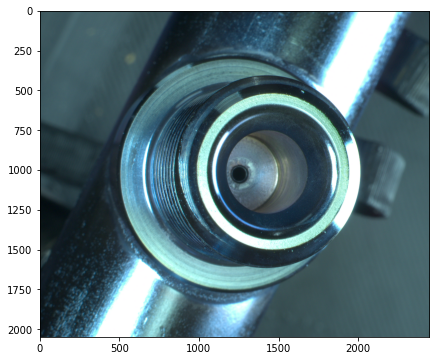

In [12]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os
import random
img_dir = "Origin_images"
image_folder = data_folder_name + "/" + img_dir + "/"

# Get a list of all files in the image folder
all_images = os.listdir(image_folder)

# Select a random image file
random_image_file = random.choice(all_images)

# Read the image
img = mmcv.imread(image_folder + random_image_file)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 show label images data</span>

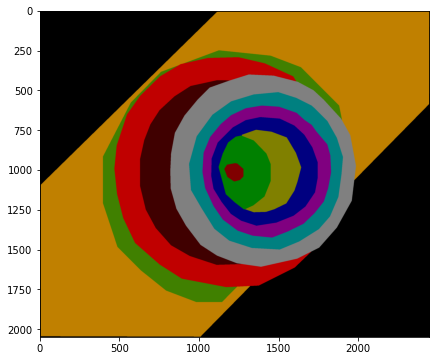

In [13]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os
import random
ann_dir = "labels_images"
image_folder = data_folder_name + "/"+ ann_dir + "/"

# Get a list of all files in the image folder
all_images = os.listdir(image_folder)

# Select a random image file
random_image_file = random.choice(all_images)

# Read the image
img = mmcv.imread(image_folder + random_image_file)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Split Train and Valid Data Set</span>

In [14]:
# split train/val set randomly
import os
import mmengine
if if_create_trian_data:
    split_dir = data_folder_name + '/splits'
    if os.path.isdir(split_dir)==False:

        mmengine.mkdir_or_exist(osp.join(split_dir))
        filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
            osp.join( mmseg_labels_set_path), suffix='.png')]
        with open(osp.join( split_dir, 'train.txt'), 'w') as f:
          # select first 4/5 as train set
          train_length = int(len(filename_list)*9/10)
          f.writelines(line + '\n' for line in filename_list[:train_length])
        with open(osp.join( split_dir, 'val.txt'), 'w') as f:
          # select last 1/5 as train set
          f.writelines(line + '\n' for line in filename_list[train_length:])

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setting base default setting</span>

In [15]:
#!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r18-d8_512x1024_80k_cityscapes/deeplabv3plus_r18-d8_512x1024_80k_cityscapes_20201226_080942-cff257fe.pth -P checkpoints

In [16]:
# !mim download mmsegmentation --config segmenter_vit-s_mask_8xb1-160k_ade20k-512x512  --dest .

In [17]:
# !mim install mmdet

In [18]:
from mmengine import Config
baseline_cfg_path = '/mmsegmentation/configs/segmenter/segmenter_vit-b_mask_8xb1-160k_ade20k-512x512.py'
# /mmsegmentation/configs/mask2former/mask2former_swin-s_8xb2-160k_xuchen-512x512.py
cfg = Config.fromfile(baseline_cfg_path)
model_name = baseline_cfg_path.split("/")[-1].split(".")[0]
print(f"config base model of :{model_name} ")

config base model of :segmenter_vit-b_mask_8xb1-160k_ade20k-512x512 


In [19]:
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/xuchen_mask_segmenter/'
cfg.data_root = data_folder_name


# cfg.train_dataloader.num_workers=2
# cfg.val_dataloader.num_workers=2
# cfg.test_dataloader.num_workers=2
# cfg.train_dataloader = cfg.data_root
# cfg.val_dataloader = cfg.data_root
# cfg.test_dataloader.num_workers = 4

# print(f'Config:\n{cfg.pretty_text}')

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setting if train and log config</span>

In [20]:
if_train = False

In [21]:
# Change the wandb username and project name below
# wnb_username = 'xuchenweights'
# wnb_project_name = model_name

# import time 
# s = time.time()
# s=time.gmtime(s)
# str_time =time.strftime("%Y-%m-%d_%H-%M-%S", s)
# #TextLoggerHook is default ，so set WandbLoggerHook
# cfg.default_hooks = [dict(type='TextLoggerHook'),
#                         dict(type='WandbLoggerHook',
#                              init_kwargs=dict(project=wnb_project_name,
#                                               name=f'exp-{model_name}-{data_folder_name}-{str_time}',
#                                               entity=wnb_username))
#                        ]

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🚀 Build Dataset and Start Training</span>

In [22]:
from mmengine.runner import Runner
if if_train:
    runner = Runner.from_cfg(cfg)

In [23]:
# start training
if if_train:
 runner.train()

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📰 Inference and Visualize Output</span>

In [24]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
# Init the model from the config and the checkpoint
checkpoint_path = cfg.work_dir +'iter_144000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: work_dirs/xuchen_mask_segmenter/iter_144000.pth


In [25]:
# 推理演示图像
import numpy as np
import pylab as plt
from matplotlib import cm
import time

# while(True):
data_address = data_folder_name +"/test_images"
how_much_file = os.listdir(data_address)
filtered_list = list(filter(lambda how_much_file: how_much_file.endswith(".png"), how_much_file))
# model.cfg=cfg
print(f"test_image_address:{data_address}")
print(f"how_much_file:{len(filtered_list)}")
print(f"image_list:{filtered_list} ")

test_image_address:powertain_goods_data/test_images
how_much_file:146
image_list:['50_3.png', '4_1.png', '52_2.png', '21_3.png', '6_1.png', '32_2.png', '58_2.png', '20_1.png', '16_1.png', '37_2.png', '12_1.png', '28_1.png', '3_2.png', '16_2.png', '57_2.png', '17_1.png', '27_3.png', '44_2.png', '7_2.png', '58_1.png', '26_2.png', '96_1.png', '41_2.png', '16_3.png', '56_1.png', '10_1.png', '63_1.png', '5_2.png', '39_2.png', '60_1.png', '51_2.png', '35_1.png', '25_2.png', '32_3.png', '64_2.png', '44_1.png', '98_3.png', '60_2.png', '53_1.png', '91_2.png', '38_2.png', '26_3.png', '63_2.png', '61_2.png', '14_1.png', '36_1.png', '15_3.png', '47_1.png', '27_1.png', '48_3.png', '59_3.png', '34_2.png', '31_3.png', '21_1.png', '47_2.png', '28_2.png', '98_2.png', '50_1.png', '62_2.png', '18_1.png', '11_1.png', '41_1.png', '15_2.png', '97_1.png', '95_1.png', '32_1.png', '31_1.png', '1_2.png', '59_2.png', '15_1.png', '59_1.png', '11_2.png', '19_2.png', '33_1.png', '6_2.png', '26_1.png', '7_1.png', '1

origin_image_path:powertain_goods_data/test_images/96_1.png
origin image size is:(2048, 2448, 3)
(2048, 2448, 3)


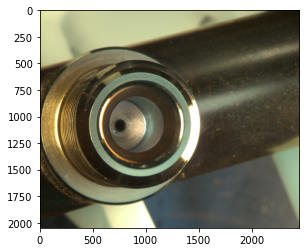

In [26]:
mmengine.mkdir_or_exist(data_folder_name + "/result/")
mmengine.mkdir_or_exist(data_folder_name + "/splited_images_result/")
import cv2
i=21
image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
img_path = image_nn + ".png"
print(f"origin_image_path:{img_path}")
img = mmcv.imread(img_path)
print(f"origin image size is:{img.shape}")
# plt.imshow(img)
# resized_img = mmcv.imrescale(img,(512,512))
# 
resized_img = img
print(resized_img.shape)
plt.imshow(resized_img)
plt.show()

In [27]:
import time
start_time = time.time()
result = inference_model(model, resized_img)
end_time = time.time()
print(f"run time is :{end_time-start_time}")

run time is :0.40404391288757324


In [28]:
vis_result = show_result_pyplot(model, resized_img, result)

05/26 00:35:19 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


save_dir:powertain_goods_data/result/96_1_result.jpg


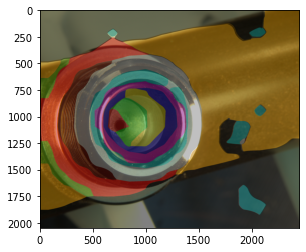

In [29]:
image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
save_dir = image_result_path + "_result.jpg"
print(f"save_dir:{save_dir}")
cv2.imwrite(save_dir,vis_result)
plt.imshow(vis_result)
plt.show()

In [30]:
# import cv2
# for i in range(len(filtered_list)):
#     start_time= time.time()
#     image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
#     img_path = image_nn + ".png"
#     print(f"origin_image_path:{img_path}")
#     img = mmcv.imread(img_path)
#     resized_img = mmcv.imrescale(img,(512,512))
#     result = inference_model(model, resized_img)
#     image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
#     save_dir = image_result_path + "_result.jpg"
#     print(f"save_dir:{save_dir}")
#     end_time = time.time()
#     print(f"speed time : {end_time-start_time}")
#     vis_result = show_result_pyplot(model, resized_img, result)
#     cv2.imwrite(save_dir,vis_result)





#     break


    # plt.imshow(mmcv.bgr2rgb(vis_result))
    # for ii in range(12):
        
    #     mask = result_map == ii
    #     # print(mask)
    #     # print(type(mask))
    #     # print(mask.shape)
    #     # plt.imshow(mask)
    #     # plt.show()
    #     # print(mask.shape)
    #     # print(mask[...,None].shape)
    #     part_image = origin_image * mask[...,None]

    #     # plt.imshow(part_image)
    #     # plt.show()
    #     imfromarray = Image.fromarray(part_image) 
        
    #     splited_images_result_folder = data_folder_name + "/splited_images_result/" + str(ii) + "/"
    #     mmcv.mkdir_or_exist(splited_images_result_folder)

    #     image_splited_images_result_path = splited_images_result_folder + filtered_list[i][0:-4]  
    #     image_name_result_parts = image_splited_images_result_path + "_part_" + str(ii) + "_result.jpg"
    #     imfromarray.save(image_name_result_parts)